## Introduction

Work in progress.

This code is part of Day 13 of the 30DayMapChallenge. I wanted to try out Datashader. Datashader is excellent for visualising big data including doing this in an interactive way. Here, it is done in a static way.

I used a dataset that I used earlier for Day 8 using HDX: [here](https://x.com/ellenarun/status/1855887672604344475).

I sampled a smaller area from this dataset in order to be able to test things out faster. The code is [here](sample_karnataka.ipynb).

This is the link I used for the 2020 data for day 8: https://data.humdata.org/dataset/india-historical-population-density-for-1975-2020-for-400m-h3-hexagons

Newer versions are available for the data. 

For the steps below, you can replace this with any dataset using geometries (other than points) or run through the basic example of the Datashader documentation. 

Although this dataset is not yet very big, it is good way to start. The reason I picked this dataset is rather than points, the geometry is in the form of a geometry (hexagon) and not the regular points (for which lots of tutorials exist) so I was curious how to plot it.

I fully followed the tutorial of Datashader and more specifically for the visualisation of polygons: https://datashader.org/user_guide/Polygons.html

The size of the dataset is not yet large but I first wanted to get some hands-on experience and start small and then gradually increase the size of the dataset. Already you can see the benefits in terms of speed of Geopandas versus datashader (please see code output below).

## Installation of packages

I will provide a more detailed later but basically what I did is that I had the ["geospatial" package](https://github.com/opengeos/geospatial) installed of Professor Quisheng Wu. With this, all the regular packages for geospatial like Geopandas, Rasterio, xarray, etc are already installed. If something is not installed just Google Search and do a conda install till you get no errors in the following cell. 

In [1]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import colorcet as cc
import datashader as ds
import datashader.transfer_functions as tf
import spatialpandas as sp
import spatialpandas.geometry
import spatialpandas.dask

In [2]:
import geopandas

Use the pyogrio engine to speed up reading. 

In [3]:
%time
df = geopandas.read_file('C:\\Ellen\\personal\\projects\\geospatial\\map_challenge_30_days\\day_8\\karnataka_population.shp', engine="pyogrio")

CPU times: total: 0 ns
Wall time: 0 ns


The shape is not yet very big.

In [4]:
df.head()

h3  population  \
0  8860323985fffff          31   
1  88603239abfffff           1   
2  88603239a5fffff          23   
3  8860327691fffff          39   
4  88603276a7fffff          74   

                                            geometry  
0  POLYGON ((77.67407 11.95448, 77.67439 11.95467...  
1  POLYGON ((77.67407 11.95448, 77.66991 11.95702...  
2  POLYGON ((77.67865 11.97692, 77.67957 11.97745...  
3  POLYGON ((77.67882 11.98692, 77.67891 11.99191...  
4  POLYGON ((77.70048 12.02419, 77.70057 12.02919...

Let us plot one geometry:

In [5]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
df.shape

(191022, 3)

In [7]:
df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

CPU times: total: 35.2 s
Wall time: 35.2 s


<Axes: >

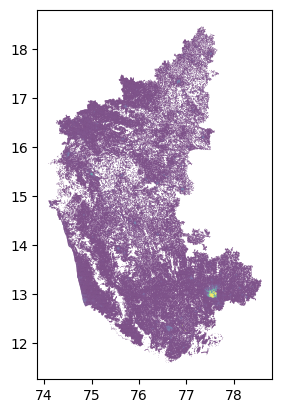

In [8]:
%%time
df.plot(column='population') # no styling

<Axes: >

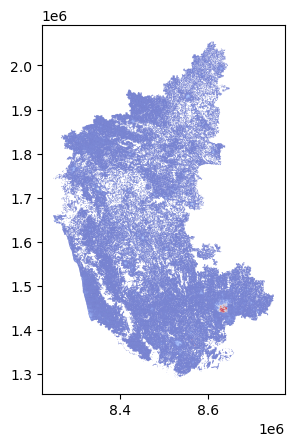

In [12]:
df.plot(column='population', cmap = 'coolwarm') # day 8 for 30DayMapChallenge but without the styling here

From here I follow the code of the tutorial and more specifically the section: "Using GeoPandas and Converting to SpatialPandas." We need to reproject here as we need to compute boundaries and centroids. Probably going forward we can use a better coordinate system though (a more local one for Karnataka)

When you have a geometry, the documentation shows that there are two ways you can visualise this: boundaries or centroids

In [13]:
df = df.to_crs(epsg=4087) # simple cylindrical projection - You need this to compute the centroids as you cannot use EPSG 4326 - need better local W
## EPSG but moving on for now
df['boundary'] = df.geometry.boundary
df['centroid'] = df.geometry.centroid
df.head()

h3  population  \
0  8860323985fffff          31   
1  88603239abfffff           1   
2  88603239a5fffff          23   
3  8860327691fffff          39   
4  88603276a7fffff          74   

                                            geometry  \
0  POLYGON ((8646637.777 1330766.797, 8646673.056...   
1  POLYGON ((8646637.777 1330766.797, 8646174.715...   
2  POLYGON ((8647148.197 1333265.041, 8647249.813...   
3  POLYGON ((8647167.137 1334377.322, 8647176.608...   
4  POLYGON ((8649578.111 1338527.001, 8649587.624...   

                                            boundary  \
0  LINESTRING (8646637.777 1330766.797, 8646673.0...   
1  LINESTRING (8646637.777 1330766.797, 8646174.7...   
2  LINESTRING (8647148.197 1333265.041, 8647249.8...   
3  LINESTRING (8647167.137 1334377.322, 8647176.6...   
4  LINESTRING (8649578.111 1338527.001, 8649587.6...   

                          centroid  
0  POINT (8646690.848 1330573.877)  
1  POINT (8646440.579 1331306.416)  
2  POINT (8647181.100 1333227.765)  
3  POINT (8647532.845 1334700.906)  
4  POINT (8649827.921 1338942.571)

At this point, you start working with Datashader. What this next step does is to determine the canvas (size of your image). Also, each point or geometry gets projected into that point:

In [14]:
cvs = ds.Canvas(plot_width=400, plot_height=650)

As mentioned in the documentation, this step is optional but I am doing it anyway. The Geopandas dataframe gets converted into a SpatialPandas GeoDataFrame.

In [15]:
sgeodf = sp.GeoDataFrame(df)
sgeodf.head()

h3  population  \
0  8860323985fffff          31   
1  88603239abfffff           1   
2  88603239a5fffff          23   
3  8860327691fffff          39   
4  88603276a7fffff          74   

                                            geometry  \
0  MultiPolygon([[[8646637.776596526, 1330766.797...   
1  MultiPolygon([[[8646637.776596526, 1330766.797...   
2  MultiPolygon([[[8647148.19698236, 1333265.0408...   
3  MultiPolygon([[[8647167.137128804, 1334377.322...   
4  MultiPolygon([[[8649578.110987058, 1338527.001...   

                                            boundary  \
0  MultiLine([[8646637.776596526, 1330766.7972642...   
1  MultiLine([[8646637.776596526, 1330766.7972642...   
2  MultiLine([[8647148.19698236, 1333265.04089820...   
3  MultiLine([[8647167.137128804, 1334377.3224864...   
4  MultiLine([[8649578.110987058, 1338527.0011918...   

                                         centroid  
0  Point([8646690.848085495, 1330573.8769108339])  
1   Point([8646440.579165235, 1331306.415878764])  
2  Point([8647181.100419091, 1333227.7647405441])  
3   Point([8647532.84510891, 1334700.9064657632])  
4    Point([8649827.9205433, 1338942.5710272312])

Here I got slightly confused in the tutorial, it seems that geometries can also be plotted. So based on the canvas, you aggregate ("agg"). This takes the mean:

CPU times: total: 0 ns
Wall time: 0 ns


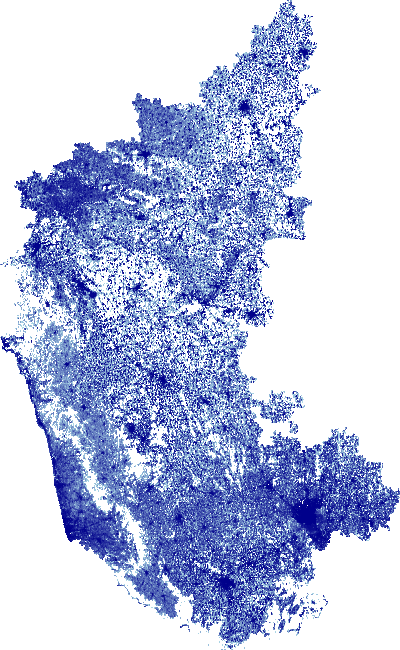

In [16]:
%time
agg = cvs.polygons(sgeodf, geometry='geometry', agg=ds.mean('population'))
tf.shade(agg)

Notice the difference in time! 

Instead, let us use the centroid points we have created above:

CPU times: total: 3.72 s
Wall time: 3.85 s


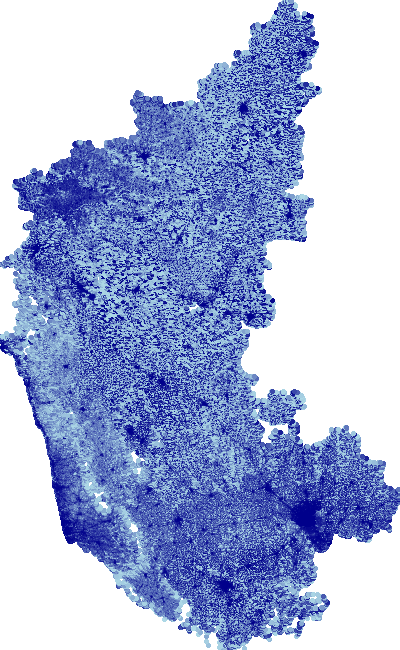

In [17]:
%%time
agg = cvs.points(sgeodf, geometry='centroid', agg=ds.mean('population'))
tf.spread(tf.shade(agg), 2)

This plot looks much better than the previous one! Play with the colors now. 

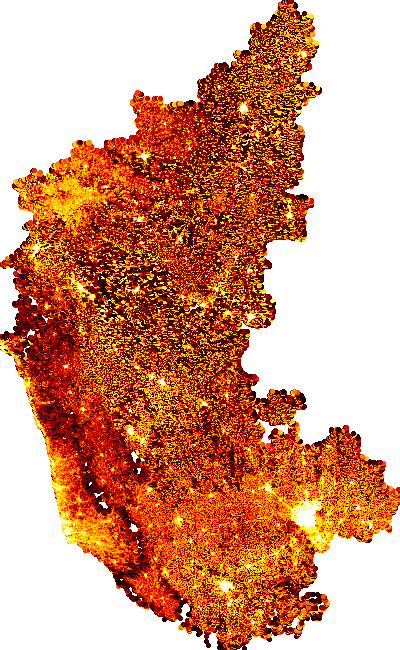

In [174]:
# Take the fire colormap from the Datashader tutorials.
agg = cvs.points(sgeodf, geometry='centroid', agg=ds.mean('population'))
tf.spread(tf.shade(agg, cmap=cc.fire), 2)

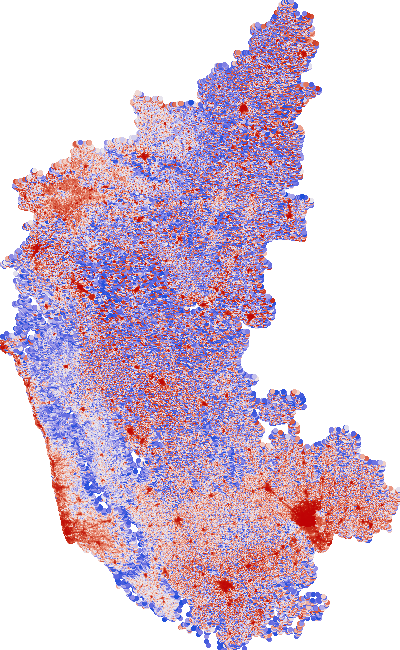

In [175]:
tf.spread(tf.shade(agg, cmap=cc.coolwarm), 2) # Trying this color map as I used this for day 8

Now adding background:

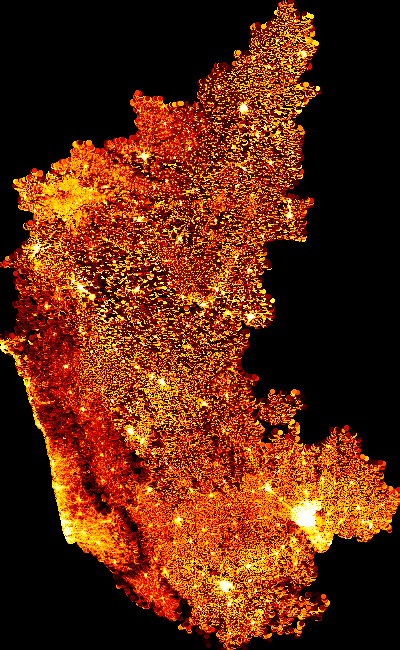

In [176]:
# Code from: https://towardsdatascience.com/big-data-visualization-using-datashader-in-python-c3fd00b9b6fc for background
tf.set_background(tf.spread(tf.shade(agg, cmap=cc.fire), 2), 'black')

## Direct support for Geopandas

Plotting without converting to a SpatialPandas GeoDataFrame. Followed the tutorial here: https://datashader.org/user_guide/Geopandas.html

In [177]:
canvas = ds.Canvas(plot_width=400, plot_height=650)

In [178]:
agg = canvas.polygons(df, geometry="geometry", agg=ds.max("population"))

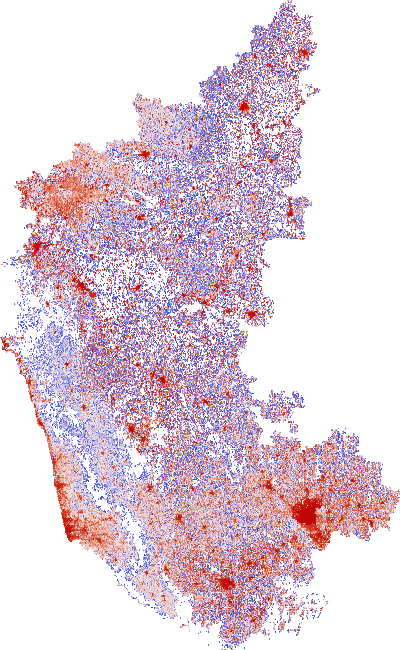

In [179]:
im = tf.shade(agg, cmap=cc.coolwarm, how="eq_hist") # Not how it is supposed to look 
tf.set_background(im, "white")

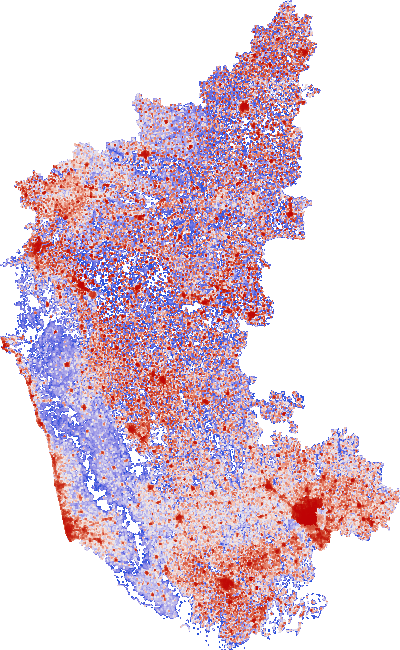

In [180]:
agg = canvas.line(df, geometry="geometry", agg=ds.max("population")) # This outlines the polygons
im = tf.shade(agg, cmap=cc.coolwarm, how="eq_hist")
tf.set_background(im, "white")

Do the graph with the points directly for Geopandas:

In [181]:
df.head()

h3  population  \
0  8860323985fffff          31   
1  88603239abfffff           1   
2  88603239a5fffff          23   
3  8860327691fffff          39   
4  88603276a7fffff          74   

                                            geometry  \
0  POLYGON ((8646637.777 1330766.797, 8646673.056...   
1  POLYGON ((8646637.777 1330766.797, 8646174.715...   
2  POLYGON ((8647148.197 1333265.041, 8647249.813...   
3  POLYGON ((8647167.137 1334377.322, 8647176.608...   
4  POLYGON ((8649578.111 1338527.001, 8649587.624...   

                                            boundary  \
0  LINESTRING (8646637.777 1330766.797, 8646673.0...   
1  LINESTRING (8646637.777 1330766.797, 8646174.7...   
2  LINESTRING (8647148.197 1333265.041, 8647249.8...   
3  LINESTRING (8647167.137 1334377.322, 8647176.6...   
4  LINESTRING (8649578.111 1338527.001, 8649587.6...   

                          centroid  
0  POINT (8646690.848 1330573.877)  
1  POINT (8646440.579 1331306.416)  
2  POINT (8647181.100 1333227.765)  
3  POINT (8647532.845 1334700.906)  
4  POINT (8649827.921 1338942.571)

In [182]:
agg = cvs.points(df, geometry='centroid', agg=ds.mean('population'))

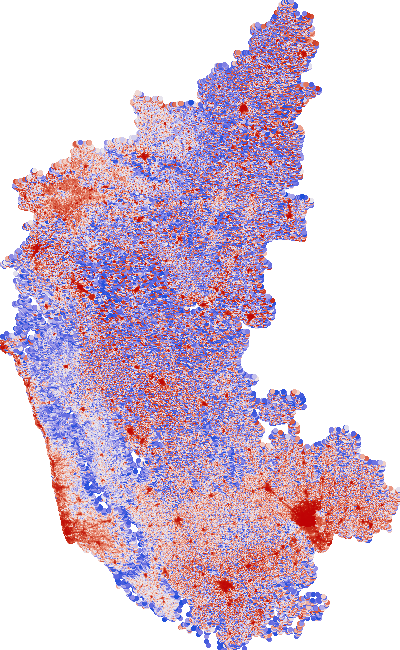

In [183]:
tf.spread(tf.shade(agg, cmap=cc.coolwarm), 2) # Trying this color map as I used this for day 8

# Exporting final image

I have not figured out how to integrate it with Matplotlib and hvplot. I do not know hvplot e.g. and with Matplotlib I ran into errors. I will export to PIL and add some basic text.

In [198]:
img=tf.spread(tf.shade(agg, cmap=cc.coolwarm), 2).to_pil() # To export the image

In [199]:
# img_raw = tf.spread(tf.shade(agg, cmap=cc.coolwarm), 2)
# Example from here: https://medium.com/tech-carnot/plotly-datashader-visualizing-large-geospatial-datasets-bea27b9d7824

In [200]:
type(img_raw)

datashader.transfer_functions.Image

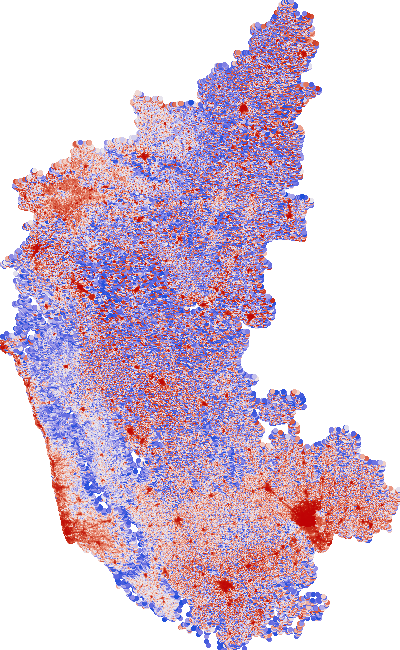

In [201]:
img

In [202]:
img.save('raw.png')

In [203]:
# type(img)

In [204]:
from PIL import Image
from PIL import ImageFont
from PIL import ImageDraw

In [205]:
# img.size

In [206]:
from PIL import Image, ImageDraw, ImageFont

In [207]:
I1 = ImageDraw.Draw(img)


In [208]:
font = ImageFont.load_default()
font_type = ImageFont.load_default(2)
I1.text((10, 590), "Ellen Brock \nPopulation Density Karnataka \nHDX data \nKontur India historical 2020", font=font, fill=(0, 0, 0))

In [209]:
# img.show()

In [210]:
img.save('test.png')

In [211]:
img.close()

## plotting with title etc. - Matplotlib

Yet to figure out. Got stuck here.

In [109]:
# https://examples.holoviz.org/gallery/census/census.html - Following code from here

## Interactive plotting - Could not get this to work yet

Does not throw an error but I cannot see anything. 99 percent because I do not know holoviews and need to explore. 

In [19]:
import holoviews as hv
from holoviews.operation.datashader import rasterize
from holoviews.streams import PlotSize
from holoviews.operation.datashader import rasterize

In [20]:
out = rasterize(hv.Polygons(df, vdims=['population']), aggregator=ds.sum('population'))
out.opts(width=700, height=500, tools=["hover"])

:DynamicMap   []

In [35]:
def compute_partitions(el):
    n = df.cx_partitions[slice(*el.range('x')), slice(*el.range('y'))].npartitions
    return el.opts(title=f'Population by hexagon for Karnataka (npartitions: {n})')

out.apply(compute_partitions).opts(frame_width=700, frame_height=500, tools=["hover"])

:DynamicMap   []

## References

https://datashader.org/user_guide/Polygons.html

https://towardsdatascience.com/big-data-visualization-using-datashader-in-python-c3fd00b9b6fc 

https://examples.holoviz.org/gallery/nyc_buildings/nyc_buildings.html - Very good for visualisation, yet to try out

https://medium.com/tech-carnot/plotly-datashader-visualizing-large-geospatial-datasets-bea27b9d7824